In [52]:
import pandas as pd
from pathlib import Path
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import re
from scipy import stats
import numpy as np
import statsmodels.api as sm
from matplotlib import colormaps
from tqdm.notebook import tqdm

from mri_data import file_manager as fm

To clarify my confusion about the bootstrapping procedure

I was confusing two things: bootstrapping the regression normally would involve selecting observations from the structure's beta's with replacement 1000 times. That definitely would not be significant, clearly.

What I am actually doing it reproducing the structures' betas 1000 times by resampling from the cohort. This is telling us something about the stability of the final line (structure betas vs distance), which may or may not be significant. 

Still something that's confusing: one procedure is to compare all the bootstrapped t_stats to the t_stat of the actual line to see how many of the bootstrapped ones were more extreme. The other is to compare them to zero. If it's invalid/uninformative to compare them to zero, it also means it's uninformative to compare them to the t_stat of another line (like the NIND line). Need to figure this out. 
- Note that doing the procedure with OIND and comparing all the t_stats to zero gives a p value of 0.072 (PMS p=0.078). So this may be valid and not something that'll always just be significant 
  - So the question is: what exactly is the p value showing is significant? That there is some amount of positive gradient? That's what the p value of the original line also tells you. **Maybe the difference is that we have more statistical power than the simple singular regression can harness, and bootstrapping over the cohort harnesses it?**
  - Since I'm comparing to 0, the p value is just telling us whether we can conclude that the slope is greater than 0. The p value for the singular regression maybe tells us whether we can conclude that the slope is as much as what it is
- Double check where I found the procedure that said compare the t_stats to the actual data's t_stat, and see what that procedure was meant to be applied to.

In [ ]:
drive_root = fm.get_drive_root()
dataroot = drive_root / "3Tpioneer_bids"
data_dir = Path("/home/srs-9/Projects/ms_mri/data")
fig_path = Path("/home/srs-9/Projects/ms_mri/choroid_thalamus_project/figures")

choroid_volumes = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/choroid_aschoplex_volumes.csv", index_col="subid"
).dropna()
tiv = pd.read_csv("/home/srs-9/Projects/ms_mri/data/tiv_data.csv", index_col="subid")

df = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/clinical_data_processed.csv", index_col="subid"
)
df = df.join([choroid_volumes, tiv])
df_z = df.copy()
numeric_cols = df.select_dtypes(include='number').columns
df_z[numeric_cols] = df_z[numeric_cols].apply(stats.zscore, nan_policy="omit")

viridis = colormaps['viridis'].resampled(20)

In [ ]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
cols_orig = df_thomas.columns
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda col: col / df_thomas['THALAMUS_1'])
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")

thalamic_nuclei = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12]
thalamic_nuclei_str = [str(i) for i in thalamic_nuclei]

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)
hips_thomas_ref.rename(columns={"struct": "struct_name"}, inplace=True)

choroid_dists = pd.read_csv(data_dir / "centroid-choroid_SDT.csv", index_col="subid")
ventricle_dists = pd.read_csv(
    data_dir / "centroid-ventricle_SDT.csv", index_col="subid"
)

In [50]:
def regress_all_nuclei(model_data, covariates, outcome, structs):
    pvals = {}
    coefs = {}
    se = {}

    if len(covariates) > 0:
        plus_covariates = f"+ {covariates}"
    else:
        plus_covariates = ""
    all_results = {}
    for struct in structs:
        formula = f"{outcome} ~ {struct} {plus_covariates}"
        res = sm.OLS.from_formula(formula, data=model_data).fit()
        pvals[struct] = res.pvalues[struct]
        coefs[struct] = res.params[struct]
        se[struct] = res.HC0_se[struct]
        all_results[struct] = res

    regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals, "se": se})
    regression_results['p_fdr'] = stats.false_discovery_control(
        regression_results['pvals'], method='bh'
    )
    regression_results = regression_results.sort_values(by="coef", ascending=True)
    regression_results.insert(0, "struct", regression_results.index)
    new_index = []
    for item in regression_results.struct:
        new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

    for i, row in regression_results.iterrows():
        if row['p_fdr'] < 0.05:
            regression_results.loc[i, 'coef_sig'] = row['coef']
        else:
            regression_results.loc[i, 'coef_sig'] = 0

    regression_results.index = new_index
    return regression_results


def plot_xordered_data(
    data, x_name, y_name, label_name, loc=(0.8, 0.05), fit_line=False
):
    fig, axes = plt.subplots(1)
    data.sort_values(by=x_name, inplace=True)
    for i, row in data.iterrows():
        c = row[x_name] / data[x_name].max()
        if 'pvals' in data.columns and data.loc[i, 'pvals'] >= 0.05:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='x',
                color=viridis(c),
                label=data.loc[i, label_name],
            )
        else:
            axes.scatter(
                data.loc[i, x_name],
                data.loc[i, y_name],
                marker='D',
                color=viridis(c),
                label=data.loc[i, label_name],
            )

    xlims = axes.get_xlim()
    ylims = axes.get_ylim()

    if fit_line:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data[x_name], data[y_name]
        )
        x = np.array([xlims[0], xlims[1]])
        y = slope * x + intercept
        plt.plot(x, y, c='black')
        text = "R2={:0.2f}\np={:0.2f}".format(r_value**2, p_value)
        text_y = ylims[0] + (ylims[1] - ylims[0]) * 0.9
        text_x = xlims[0] + (xlims[1] - xlims[0]) * 0.05
        axes.text(text_x, text_y, text)

    axes.set_xbound([xlims[0], xlims[1] * 1.1])
    fig.legend(loc=loc)

    return fig, axes

(<Figure size 640x480 with 1 Axes>, <Axes: >)

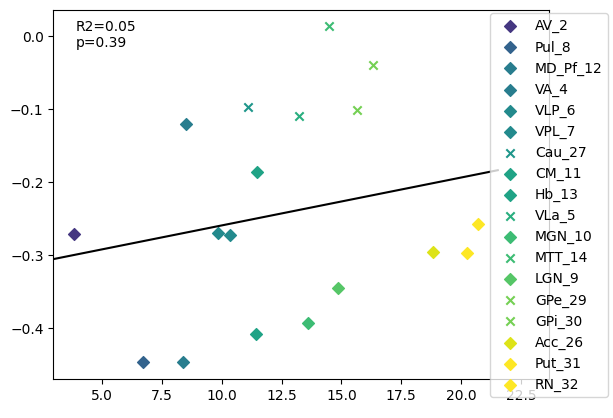

In [51]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type2'] == "MS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True)

In [ ]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type2'].isin(["MS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female"
outcome = "choroid_volume"

n_boots = 1000
t_stats_ms = np.zeros((n_boots,))
slopes_ms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_ms[i_samp] = (slope / std_err)
    slopes_ms[i_samp] = slope

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapped p: 0.00


(<Figure size 640x480 with 1 Axes>, <Axes: >)

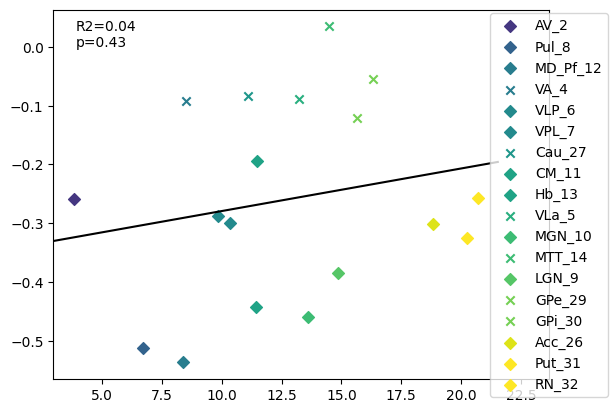

In [64]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "RMS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True)

In [ ]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["RMS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female"
outcome = "choroid_volume"

n_boots = 1000
t_stats_pms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_pms[i_samp] = (slope / std_err)

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapped p: 0.00


(<Figure size 640x480 with 1 Axes>, <Axes: >)

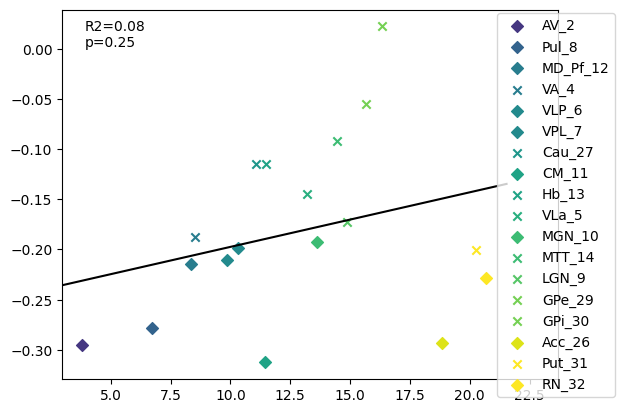

In [62]:
model_data = df_z.join([df_thomas_z])
model_data = model_data[model_data['dz_type5'] == "PMS"]
structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female + tiv"
outcome = "choroid_volume"

regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)

data = regression_results.copy()
for i in data.index:
    data.loc[i, 'dist'] = choroid_dists[str(i)].mean()

plot_xordered_data(data, "dist", "coef", "struct", fit_line=True)

In [ ]:
df_to_sample = df_z.join([df_thomas_z])
df_to_sample = df_to_sample[df_to_sample['dz_type5'].isin(["PMS"])]
df_to_sample = df_to_sample.reset_index()
df_dists_to_sample = choroid_dists.reset_index()

structs = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1", "Amy_34", "GP_33", "Cla_28"])]
covariates = "age + Female"
outcome = "choroid_volume"

n_boots = 1000
t_stats_pms = np.zeros((n_boots,))
for i_samp in tqdm(range(n_boots)):
    inds = np.random.randint(0, df_to_sample.index.max(), len(df_to_sample))
    model_data = df_to_sample.loc[inds, :]
    dists = df_dists_to_sample.loc[inds, :]

    regression_results = regress_all_nuclei(model_data, covariates, outcome, structs)
    data = regression_results.copy()
    for i in data.index:
        data.loc[i, 'dist'] = dists[str(i)].mean()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data['dist'], data['coef'])
    t_stats_pms[i_samp] = (slope / std_err)

slopes_ms.sort()
mean_slope = slopes_ms.mean()
print("Slope: {:0.2} [{:0.2}, {:0.2}]".format(mean_slope, slopes_ms[25], slopes_ms[975]))

p_boot = sum(t_stats_ms <= 0) / n_boots
print("Bootstrapped p: {:0.2f}".format(p_boot))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [59]:
t_stats_pms

array([ 1.73976901, -0.3758409 ,  1.90793005,  1.26077537,  1.31948155,
        2.0213551 , -0.33305541,  0.2246131 ,  1.35921462,  1.62327371,
        0.30462528, -0.97896493,  0.8965971 ,  2.31098061,  0.33515612,
        2.19271535,  0.70849485,  0.63631285,  0.26826287,  1.09019341,
        1.66042134,  2.78738497,  2.53905528,  1.59168735,  2.34077925,
        0.360122  ,  0.82390332,  1.27221482,  1.01857097,  0.69656133,
        3.69650484,  0.83358586,  0.43307949,  2.75511047,  1.23142898,
        1.69376873,  0.39989245,  0.40065271,  1.79725941,  1.11390879,
        0.39102222,  3.01221924,  0.93227131,  1.52608043,  1.44462738,
        0.94360622,  3.5334606 ,  0.30476275,  2.55370613,  1.39575465,
        2.09754948,  1.15282795,  2.00368374,  1.93552847,  1.24400524,
        1.6679299 ,  0.84418165,  0.7999572 ,  3.28512882,  1.03572481,
        0.9037967 ,  0.98572215,  1.30739014,  1.97467057,  1.3581135 ,
        0.31597142,  1.38365801,  1.37988944,  2.52114585,  0.65